In [1]:
import numpy as np
import pandas as pd
import json

from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
metadata = pd.read_csv('DES_VT_Subject_Export.csv')
metadata = metadata[metadata['workflow_id'] == 25011]
ok_class = ['single_cand', 'double_cand', 'inter_cand']
subject_ids, my_ids, cand_class = [], [], []

for (index, row) in metadata.iterrows():
    data_tmp = json.loads(row['metadata'])#[str(row['subject_ids'])]
    if(not(data_tmp['#CLASS'] in ok_class)):
        continue
    cand_class.append(data_tmp['#CLASS'])
    subject_ids.append(int(row['subject_id']))
    my_ids.append(int(data_tmp['#NEW_ID']))

In [3]:
complete_metadata = pd.DataFrame()
complete_metadata['class'] = cand_class
complete_metadata['subject_id'] = subject_ids
complete_metadata['my_ids'] = my_ids

complete_metadata = complete_metadata.drop_duplicates()
print(len(complete_metadata))
complete_metadata.head()

22564


,class,subject_id,my_ids
0,double_cand,92396146,0
1,double_cand,92396147,1
2,double_cand,92396148,2
3,double_cand,92396149,3
4,double_cand,92396150,4


In [4]:
results = pd.read_csv('DES_VT_Subjects_18_Oct_1800_BST.csv')

mask = complete_metadata['subject_id'].isin(results['subject_id'])
complete_metadata[mask]

key_data = complete_metadata.merge(results[['subject_id', 'score']], on='subject_id', how='left').dropna()
key_data = key_data.rename({'my_ids': '#NEW_ID'}, axis=1)
print(len(key_data))
key_data.tail()

18908


,class,subject_id,#NEW_ID,score
22559,single_cand,92418733,20021,0.000036
22560,single_cand,92418734,20022,0.009778
22561,single_cand,92418735,20023,0.003550
22562,single_cand,92418736,20025,0.000006
22563,single_cand,92418737,20024,0.000215


In [5]:
def make_plot_all(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%7 == 0):
            plt.figure(figsize=(12,2))
            for j in range(7):
                if(i+j > len(objects)-1): break
                plt.subplot(1,7,j+1)
                expo = "{:e}".format(data['score'].iloc[i+j]).split('e')[1]
                reported = 'T' if data['#REPORTED'].iloc[i+j] else 'F'
                color = 'lime' if data['#REPORTED'].iloc[i+j] else 'aqua'
                title = '{:.7f} {}'.format(data['score'].iloc[i+j], reported)
                plt.title(title, color=color)
                #print(data['COADD_OBJECT_ID'].iloc[i+j]) 
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            #plt.savefig(png_filepath + title + '.png', bbox_inches='tight')
        plt.show() 

1928
1625


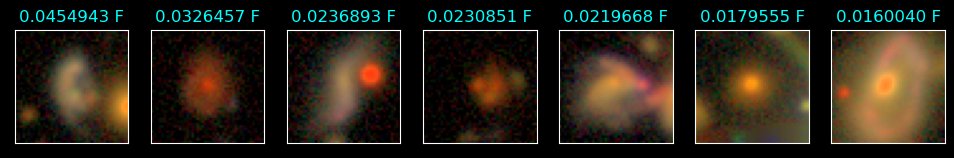

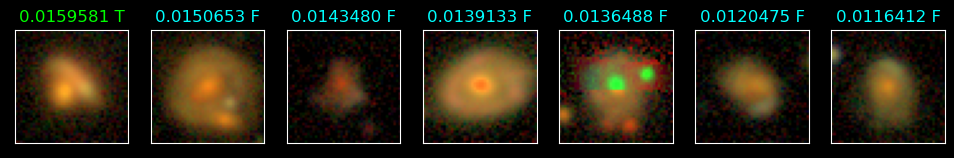

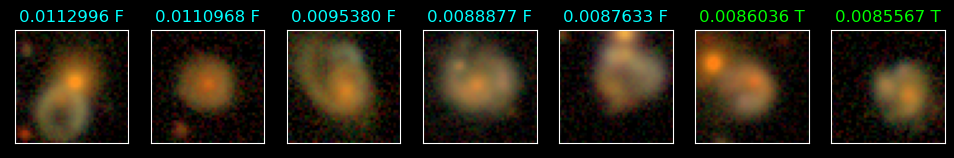

In [6]:
#double candidates
path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/fit_files/'
mani_path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/to_upload/'

hdu_list = fits.open(path + 'double.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
key_data_tmp = key_data[key_data['class'] == 'double_cand']
print(len(data))

data_mani = pd.read_csv(mani_path + 'double/doub_complete_manifest.csv')

data = data.merge(data_mani[['COADD_OBJECT_ID', '#NEW_ID', '#CLASS', '#REPORTED']], on='COADD_OBJECT_ID', how='left').dropna()
data = data.merge(key_data_tmp[['#NEW_ID', 'subject_id', 'score']], on='#NEW_ID', how='left').dropna()
print(len(data))

new_data = data.sort_values(by='score', ascending=False)
images = images[new_data.index]
data = new_data.reset_index(drop=True)

n = 21
make_plot_all(images[0:n], 'title', data.iloc[0:n], 9, 45, (0, 0, 0))

610
531


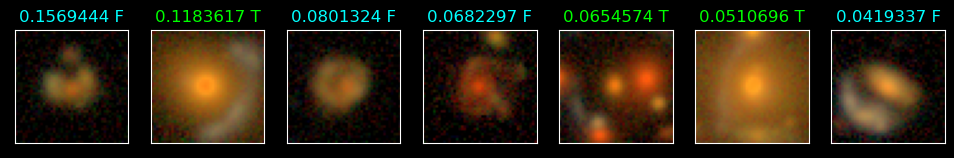

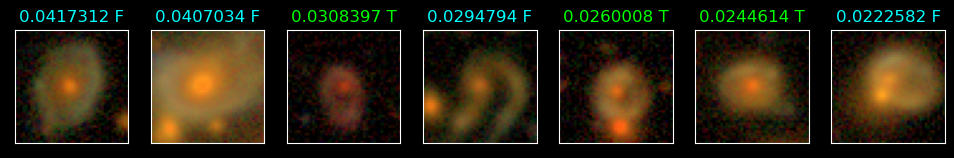

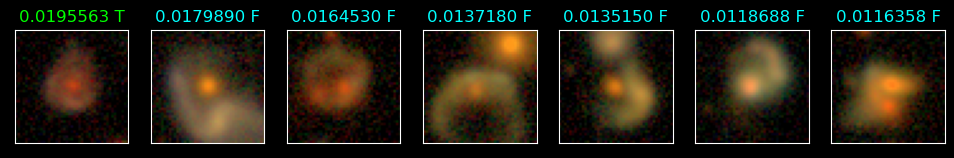

In [7]:
#candidates in intersection
path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/fit_files/'
mani_path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/to_upload/'

hdu_list = fits.open(path + 'inter.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
key_data_tmp = key_data[key_data['class'] == 'inter_cand']
print(len(data))

data_mani = pd.read_csv(mani_path + 'inter/inter_complete_manifest.csv')

data = data.merge(data_mani[['COADD_OBJECT_ID', '#NEW_ID', '#CLASS', '#REPORTED']], on='COADD_OBJECT_ID', how='left').dropna()
data = data.merge(key_data_tmp[['#NEW_ID', 'subject_id', 'score']], on='#NEW_ID', how='left').dropna()
print(len(data))

new_data = data.sort_values(by='score', ascending=False)
images = images[new_data.index]
data = new_data.reset_index(drop=True)

n = 21
make_plot_all(images[0:n], 'title', data.iloc[0:n], 9, 45, (0, 0, 0))

In [8]:
#single candidates
path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/fit_files/'
mani_path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/to_upload/'

hdu_list = fits.open(path + 'single.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
key_data_tmp = key_data[key_data['class'] == 'single_cand']
print(len(data))

data_mani = pd.read_csv(mani_path + 'single/sing_complete_manifest.csv')

data = data.merge(data_mani[['COADD_OBJECT_ID', '#NEW_ID', '#CLASS', '#REPORTED']], on='COADD_OBJECT_ID', how='left').dropna()
data = data.merge(key_data_tmp[['#NEW_ID', 'subject_id', 'score']], on='#NEW_ID', how='left').dropna()
print(len(data))

new_data = data.sort_values(by='score', ascending=False)
images = images[new_data.index]
data = new_data.reset_index(drop=True)

20026
16752


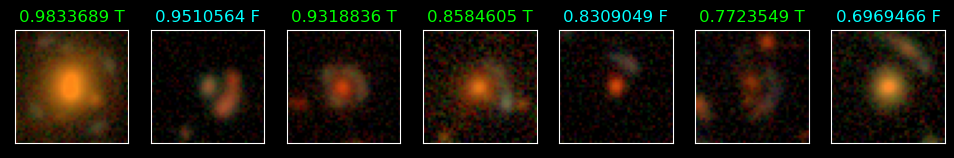

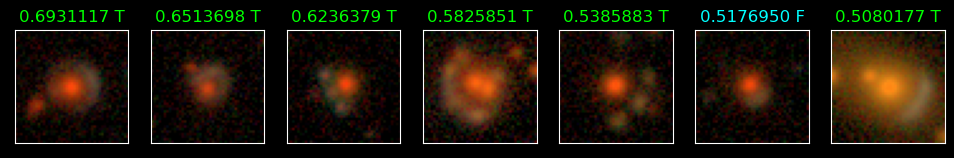

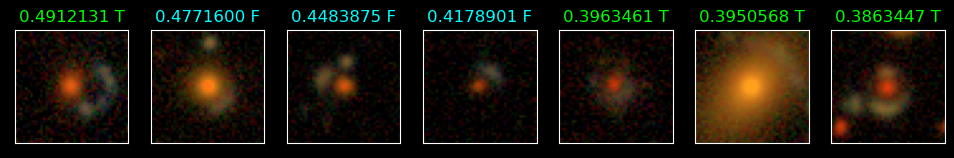

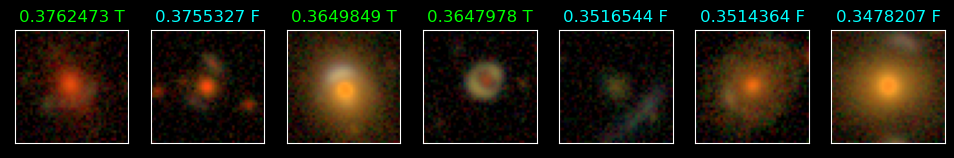

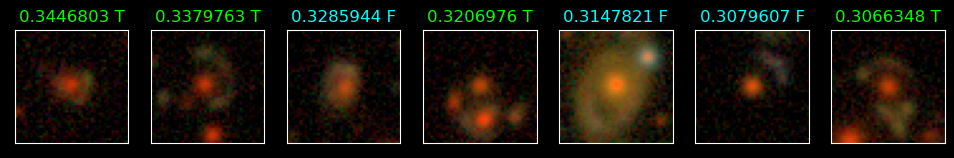

In [11]:
n = 35
make_plot_all(images[0:n], 'title', data.iloc[0:n], 9, 45, (0, 0, 0))

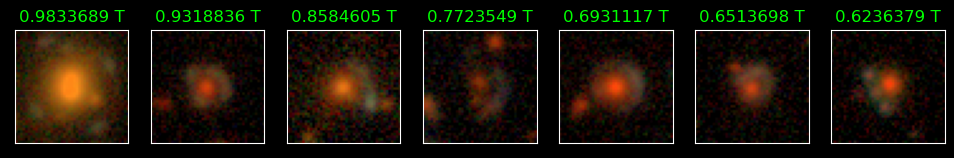

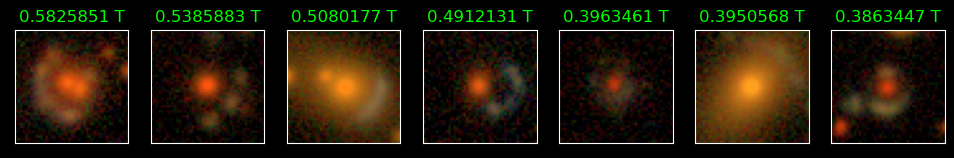

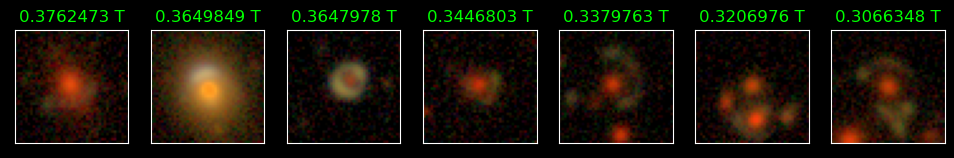

In [10]:
data_tmp = data[data['#REPORTED'] == True]
images_tmp = images[data_tmp.index]
n = 21 #len(data_tmp)
make_plot_all(images_tmp[0:n], 'title', data_tmp.iloc[0:n], 9, 45, (0, 0, 0))